In [0]:
!pip install pymagnitude pytorch_pretrained_bert -q

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regex as re
from pymagnitude import Magnitude
from pytorch_pretrained_bert import BertTokenizer, BertForSequenceClassification, BertAdam
from tqdm import tqdm, tqdm_notebook

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from IPython.core.display import display, HTML

tqdm.pandas()

# If the machine you run this on has a GPU available with CUDA installed,
# use it. Using a GPU for learning often leads to huge speedups in training.
# See https://developer.nvidia.com/cuda-downloads for installing CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# Fine-Tuning BERT for Text Classification

While transfer learning has had a huge impact on image-based deep learning tasks, transfer learning is still a relatively new concept in NLP. The idea is that you first train a large model on a huge amount of data, and then you fine-tune the model on a smaller subset of data.

For example, we can train a large model on all of Wikipedia, then fine-tune our model on blog posts about statistics in order for our model to be able to identify the names of people in the blog posts about statistics. The model is able to leverage general understanding of language from Wikipedia to the specific task of identifying people in statistics blog posts.

For more details on how BERT works, I recommend reading [The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)](https://jalammar.github.io/illustrated-bert/).

## Specify hyperparameters and other variables

- **Learning rate**: How quickly the model learns. If it's too low, the model will learn very slowly. If it's too high, the model won't be able to learn at all. The goal is to have as high as value as we can get away with.

- **Batch size**: How many examples for the model to see at once. If it's too low, the model will train very slowly. If it's too high, you will run out of memory. The goal isn't necessarily to have the highest value you can get away with here. It really depends on the circumstances. For fine-tuning BERT, the recommended batch size is ony 32. Usually you will see batch sizes of 16, 32, 64, 128, or 256.

Note that learning rate should be lower than what you maybe are used to (eg. 1e-5 instead of 1e-3), as we are only fine-tuning the BERT model instead of training it from scratch. We don't want the model's parameters to drastically change as that will likely result in a decrease in model performance.

In [0]:
BATCH_SIZE = 32
LEARNING_RATE = 5e-4

# Will be downloaded in the cell below
DATA_FILE = 'data/Train.csv'
MAPPING_FILE = 'data/Mapping.csv'

## Download the training data

We will download the data from [Kaggle](https://www.kaggle.com/hariharasudhanas/twitter-emoji-prediction) using the [Kaggle API](https://github.com/Kaggle/kaggle-api). Unfortunately, you will have to create a Kaggle account and [generate an API key](https://github.com/Kaggle/kaggle-api#api-credentials) to download this dataset.

Kaggle is a great place to go to enter in machine learning competitions.

In [4]:
# Add your own Kaggle username and API key here!
!KAGGLE_USERNAME=XXX KAGGLE_KEY=XXX kaggle datasets download -d hariharasudhanas/twitter-emoji-prediction

!unzip twitter-emoji-prediction.zip -d data/
!rm twitter-emoji-prediction.zip

  0% 0.00/3.47M [00:00<?, ?B/s]
100% 3.47M/3.47M [00:00<00:00, 56.3MB/s]
Archive:  twitter-emoji-prediction.zip
replace data/Train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data/Train.csv          
  inflating: data/Test.csv           
  inflating: data/OutputFormat.csv   
  inflating: data/Mapping.csv        


## Preprocess the data

This part might look a little weird as BERT expects the inputs of the model to have these `[CLS]` and `[SEP]` tokens. As well, BERT expects masks and segments.

I found details on this convention [here](https://github.com/huggingface/pytorch-pretrained-BERT/blob/master/examples/run_classifier.py#L251), reproduced below.

    The convention in BERT is:
    (a) For sequence pairs:
        tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
    (b) For single sequences:
        tokens:   [CLS] the dog is hairy . [SEP]
        type_ids: 0   0   0   0  0     0 0

    Where "type_ids" are used to indicate whether this is the first sequence or the second sequence. The embedding vectors for `type=0` and `type=1` were learned during pre-training and are added to the wordpiece embedding vector (and position vector). This is not *strictly* necessary since the [SEP] token unambigiously separates the sequences, but it makes it easier for the model to learn the concept of sequences.

    For classification tasks, the first vector (corresponding to [CLS]) is used as as the "sentence vector". Note that this only makes sense because the entire model is fine-tuned.
    
    The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
    
Note that `type_ids` corresponds to the term `segments`. Of course, if you read the paper these oddities will make more sense.



In [0]:
class TwitterEmojiDataset(Dataset):
    def __init__(self, data_filename, mapping_filename):
        df = pd.read_csv(data_filename, index_col=0).iloc[:10000]  # TODO: Remove limit
        
        labels_df = pd.read_csv(mapping_filename, index_col=0)
        self.idx2emoji = dict(zip(labels_df.number.tolist(), labels_df.emoticons.tolist()))
        
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        df['tokenized_text'] = df.TEXT.progress_apply(self.tokenizer.tokenize)

        # Add Bert-specific beginning and end tokens
        df.loc[:, 'tokenized_text'] = df.tokenized_text.apply(
            lambda tokens: ['[CLS]'] + tokens + ['[SEP]'],
        )
        
        df['indexed_tokens'] = df.tokenized_text.progress_apply(
            self.tokenizer.convert_tokens_to_ids,
        )
        
        sequences = df.indexed_tokens.tolist()
        max_sequence_length = max(len(x) for x in sequences)
        
        self.inputs_lst, self.masks, self.segments = [], [], []
        for sequence in sequences:
            self.inputs_lst.append(sequence + (max_sequence_length - len(sequence)) * [0])
            self.masks.append(len(sequence) * [1] + (max_sequence_length - len(sequence)) * [0])
            self.segments.append(max_sequence_length * [0])
            
        self.targets = df.Label.tolist()
        self.texts = df.TEXT.tolist()

    def __getitem__(self, i):
        return self.inputs_lst[i], self.masks[i], self.segments[i], self.targets[i], self.texts[i]
    
    def __len__(self):
        return len(self.inputs_lst)

In [4]:
dataset = TwitterEmojiDataset(DATA_FILE, MAPPING_FILE)

100%|██████████| 10000/10000 [00:00<00:00, 135916.58it/s]


## Setup the batches

In order to avoid overloading the GPU (or CPU) memory, we have the model learn from batches of examples rather than all examples at once.

First, however, we need to split our dataset into training, validation, and testing sets.

- **Training**: data the model learns from
- **Validation**: data to evaluate with for hyperparameter tuning (make sure the model doesn't overfit!)
- **Testing**: data to evaluate the final performance of the model

In [5]:
def split_train_valid_test(corpus, valid_ratio=0.1, test_ratio=0.1):
    """Split dataset into train, validation, and test."""
    test_length = int(len(corpus) * valid_ratio)
    valid_length = int(len(corpus) * test_ratio)
    train_length = len(corpus) - valid_length - test_length
    return random_split(
        corpus, lengths=[train_length, valid_length, test_length],
    )

train_dataset, valid_dataset, test_dataset = split_train_valid_test(
    dataset, valid_ratio=0.05, test_ratio=0.05)
len(train_dataset), len(valid_dataset), len(test_dataset)

(9000, 500, 500)

In [0]:
def collate(batch):
    inputs = torch.LongTensor([item[0] for item in batch])
    mask = torch.LongTensor([item[1] for item in batch])
    segment = torch.LongTensor([item[2] for item in batch])
    target = torch.LongTensor([item[3] for item in batch])
    text = [item[4] for item in batch]
    
    inputs, mask, segment, target = map(
        lambda x: x.to(device),
        (inputs, mask, segment, target),
    )

    return inputs, mask, segment, target, text

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate)

## Train the model

We will train the smaller model `bert-base-uncased` as the larger one has problems fitting into memory. A multi-GPU setup is likely needed for training the larger model. You can find the full list of possible models [here](https://github.com/huggingface/pytorch-pretrained-BERT#loading-google-ai-or-openai-pre-trained-weigths-or-pytorch-dump).

In [0]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(dataset.idx2emoji),
)
model = model.to(device)

param_optimizer = list(model.classifier.named_parameters()) 
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer]}]
optimizer = BertAdam(optimizer_grouped_parameters, lr=LEARNING_RATE)

In [0]:
def train_epoch(model, optimizer, train_loader):
    model.train()
    train_loss = total = 0
    for inputs, mask, segment, target, text in tqdm_notebook(train_loader, desc='Training', leave=False):
        optimizer.zero_grad()
        
        loss = model(inputs, segment, mask, target)

        train_loss += loss.item()
        total += 1
        
        loss.backward()
        optimizer.step()
        
    return train_loss / total


def validate_epoch(model, valid_loader):
    model.eval()
    with torch.no_grad():
        valid_loss = total = 0
        for inputs, mask, segment, target, text in tqdm_notebook(valid_loader, desc='Validating', leave=False):
            loss = model(inputs, segment, mask, target)

            valid_loss += loss.item()
            total += 1

        return valid_loss / total

In [9]:
n_epochs = 0
train_losses, valid_losses = [], []
#while True:
for _ in range(5):
    train_loss = train_epoch(model, optimizer, train_loader)
    valid_loss = validate_epoch(model, valid_loader)
    
    tqdm.write(
        f'epoch #{n_epochs + 1:3d}\ttrain_loss: {train_loss:.3f}\tvalid_loss: {valid_loss:.3f}\n',
    )
    
    # Early stopping if the current valid_loss is
    # greater than the last three valid losses
    if len(valid_losses) > 2 and all(valid_loss > loss for loss in valid_losses[-3:]):
        print('Stopping early')
        break
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    n_epochs += 1

epoch #  1	train_loss: 2.787	valid_loss: 2.712



epoch #  2	train_loss: 2.692	valid_loss: 2.686



epoch #  3	train_loss: 2.666	valid_loss: 2.667



epoch #  4	train_loss: 2.645	valid_loss: 2.654



epoch #  5	train_loss: 2.631	valid_loss: 2.646



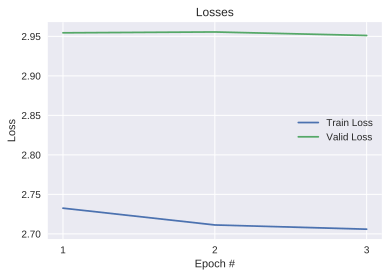

In [14]:
epoch_ticks = range(1, n_epochs + 1)
plt.plot(epoch_ticks, train_losses)
plt.plot(epoch_ticks, valid_losses)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

## Predictions

In [15]:
def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)


model.eval()
test_accuracy = n_examples = 0
with torch.no_grad():
    for inputs, mask, segment, target, text in test_loader:
        inputs, mask, segment = map(reshape, (inputs, mask, segment))
        target = target.to(device)

        optimizer.zero_grad()

        loss = model(inputs, segment, mask, target)
        logits = model(inputs, segment, mask)
        
        logits = logits.detach().cpu().numpy()
        target = target.cpu().numpy()
        
        test_accuracy += accuracy(logits, target)
        n_examples += inputs.size(0)
        
print(test_accuracy / n_examples)

0.26


In [0]:
flatten = lambda x: [sublst for lst in x for sublst in lst]
inputs_lst, mask_lst, segment_lst, target_lst, text_lst = zip(*test_loader)
inputs_lst, target_lst, tokens_lst, text_lst = map(flatten, [inputs_lst, target_lst, tokens_lst, text_lst])
test_examples = list(zip(inputs_lst, target_lst, tokens_lst, text_lst))

def print_random_prediction(n=10):
    model.eval()
    rows = []
    for _ in range(n):
        with torch.no_grad():
            inputs, target, segment, target, text = random.choice(test_examples)
            inputs, mask, segment = map(reshape, (inputs, mask, segment))
            
            target = target.item()
            
            _, logits = model([inputs], return_activations=True)
            logits = logits.detach().cpu().numpy()
            prediction = np.argmax(logits, axis=1)[0]

            predicted = dataset.idx2emoji[prediction]
            actual = dataset.idx2emoji[target]
            
            row = f"""
            <tr>
            <td>{text}&nbsp;</td>
            <td>{predicted}&nbsp;</td>
            <td>{actual}&nbsp;</td>
            </tr>
            """
            rows.append(row)
            
    rows_joined = '\n'.join(rows)
    table = f"""
<table>
<tbody>
<tr>
<td><b>Tweet</b>&nbsp;</td>
<td><b>Predicted</b>&nbsp;</td>
<td><b>Actual</b>&nbsp;</td>
</tr>
{rows_joined}
</tbody>
</table>
"""
    display(HTML(table))

In [0]:
print_random_prediction(n=30)